In [1]:
import pandas as pd
from maps.screens import ImageScreenMultiAntibody
from maps.multiantibody.config import TrainConfig, ModelConfig, DataLoaderConfig
import json
import torch
import umap

import sys
sys.path.append("/home/kkumbier/maps/")
import maps.multiantibody.data_loaders as data_loaders
import maps.multiantibody.models as models
import maps.multiantibody.training as training

# --- Initialize parameters ---
pdir = "/home/kkumbier/als/scripts/maps/template_analyses/params/"
with open(pdir + "maps_multiantibody-train-multiclass.json", "r") as f:
    train_params = json.load(f)
    
with open(pdir + "maps_multiantibody-test-multiclass.json", "r") as f:
    test_params = json.load(f)

dataloader_config = DataLoaderConfig()
train_config = TrainConfig()
model_config = ModelConfig()
model_config.n_classes = 4

antibodies = ["HSP70/SOD1", "FUS/EEA1", "COX IV/Galectin3/atubulin"]
print(json.dumps(train_params, indent=4))


{
    "name": "maps_dmso",
    "screen": "20250216_AWALS37_Full_screen_n96",
    "root": "/awlab/projects/2024_ALS/Experiments",
    "data_file": "Objects_Population - Nuclei Selected.txt",
    "eval_dir": "Evaluation1",
    "preprocess": {
        "drop_na_features": {
            "na_prop": 0.1
        },
        "drop_sample_by_feature": {
            "drop_key": [
                {
                    "CellLines": [
                        "C9014",
                        "NS048"
                    ]
                }
            ]
        },
        "select_sample_by_feature": {
            "select_key": [
                {
                    "Drugs": [
                        "DMSO"
                    ],
                    "Mutations": [
                        "FUS",
                        "WT",
                        "SOD1",
                        "C9orf72"
                    ],
                    "CellLines": [
                        "NS007",
                        

In [2]:
# Load and process screens for train / test
train_screen = ImageScreenMultiAntibody(train_params)
train_screen.load(antibody=antibodies)

test_screen = ImageScreenMultiAntibody(test_params)
test_screen.load(antibody=antibodies)

print("Processing training set...")
train_screen.preprocess()

print("Processing test set...")
test_screen.preprocess()

for ab in  antibodies:
    print(f"Marker set: {ab}")
    print(f"Train data: {train_screen.data[ab].shape}")
    print(f"Test data: {test_screen.data[ab].shape}")

Processing training set...
Processing test set...
Marker set: HSP70/SOD1
Train data: (17685, 311)
Test data: (81834, 311)
Marker set: FUS/EEA1
Train data: (18154, 315)
Test data: (84098, 315)
Marker set: COX IV/Galectin3/atubulin
Train data: (17074, 312)
Test data: (78320, 312)


In [4]:
dataloader_config

DataLoaderConfig(response='Mutations', grouping='CellLines', batch_size=6, n_cells=50, shuffle=True, mode='train', scale=True, response_map={'WT': 0, 'FUS': 1})

In [5]:
import importlib
importlib.reload(data_loaders)
create_multiantibody_dataloader = data_loaders.create_multiantibody_dataloader


dataloader_config.batch_size = 6
dataloader_config.response_map = {"WT": 0, "FUS": 1, "SOD1": 2, "C9orf72": 3}

train_dataloader = create_multiantibody_dataloader(
    train_screen,
    **vars(dataloader_config)
)

scalers = train_dataloader._get_scalers()
dataloader_config.mode = "eval"
test_dataloader = create_multiantibody_dataloader(
    test_screen,
    scalers=scalers,
    **vars(dataloader_config)
)

In [6]:
importlib.reload(training)
importlib.reload(models)
train = training.train
MultiAntibodyClassifier = models.MultiAntibodyClassifier

# Initiaize model and train
train_config.n_epochs = 100
train_config.patience = 10
train_config.lr = 1e-3

model_config.antibody_feature_dims = train_dataloader._get_feature_dims()
model_config.d_model = 16
model_config.n_layers = 1

model = MultiAntibodyClassifier(**vars(model_config))
train(model, train_dataloader, train_config)

Epoch 1/100, Cell Loss: 1.5157, Line Loss: 2.4212
  COX IV/Galectin3/atubulin - Cell Loss: 1.5004, Cell Acc: 0.2633
  FUS/EEA1 - Cell Loss: 1.5371, Cell Acc: 0.2367
  HSP70/SOD1 - Cell Loss: 1.5096, Cell Acc: 0.2350
Epoch 2/100, Cell Loss: 1.4808, Line Loss: 2.2082
  COX IV/Galectin3/atubulin - Cell Loss: 1.4935, Cell Acc: 0.2500
  FUS/EEA1 - Cell Loss: 1.4659, Cell Acc: 0.2817
  HSP70/SOD1 - Cell Loss: 1.4831, Cell Acc: 0.2450
Epoch 3/100, Cell Loss: 1.5006, Line Loss: 1.9418
  COX IV/Galectin3/atubulin - Cell Loss: 1.4807, Cell Acc: 0.2800
  FUS/EEA1 - Cell Loss: 1.5096, Cell Acc: 0.2700
  HSP70/SOD1 - Cell Loss: 1.5115, Cell Acc: 0.2317
Epoch 4/100, Cell Loss: 1.4582, Line Loss: 1.8854
  COX IV/Galectin3/atubulin - Cell Loss: 1.4647, Cell Acc: 0.2617
  FUS/EEA1 - Cell Loss: 1.4509, Cell Acc: 0.2950
  HSP70/SOD1 - Cell Loss: 1.4590, Cell Acc: 0.2683
Epoch 5/100, Cell Loss: 1.4542, Line Loss: 1.7300
  COX IV/Galectin3/atubulin - Cell Loss: 1.4324, Cell Acc: 0.3083
  FUS/EEA1 - Cell Lo

In [7]:
model.eval()
probs_line = []
probs_cell = {}
labels = []
cell_lines = []
embeddings = {}

device = next(model.parameters()).device  # Get device from model parameters
test_dataloader.batch_size
with torch.no_grad():
    for batch in test_dataloader:
        if batch is None:
            continue
        
        x_dict = {ab: batch[ab][0].to(device) for ab in batch}
        y_line = batch[list(batch.keys())[0]][1].to(device)
        cell_lines.extend([batch[list(batch.keys())[0]][-1]])

        cell_logits, line_logits, embs = model(
            x_dict, return_embedding=True
        )        
        
        labels.append(y_line.cpu())
        probs_line.append(torch.softmax(line_logits, dim=-1).cpu())

        for ab in cell_logits:
            if ab not in probs_cell:
                probs_cell[ab] = []        
            probs_cell[ab].append(torch.softmax(cell_logits[ab], dim=-1).cpu())
        
        for ab in embs:
            if not ab in embeddings:
                embeddings[ab] = []
            embeddings[ab].append(embs[ab].cpu())

# Merge outputs over cell lines
probs_line = torch.cat(probs_line)           
labels = torch.cat(labels)
probs_cell = {k: torch.cat(v).mean(dim=1) for k, v in probs_cell.items()}
embeddings = {k: torch.cat(v) for k, v in embeddings.items()}

In [12]:
# Create DataFrame with aggregate class probabilities from probs_line
df = pd.DataFrame(probs_line.numpy())
df.columns = [f"class_{i}_agg" for i in df.columns]

# Add per-antibody class probabilities from probs_cell
for ab in probs_cell:
    dfab = pd.DataFrame(probs_cell[ab].numpy())
    dfab.columns = [f"class_{i}_{ab}" for i in dfab.columns]
    df = pd.concat([df, dfab], axis=1)

df["CellLines"] = cell_lines
df["True"] = labels.numpy()

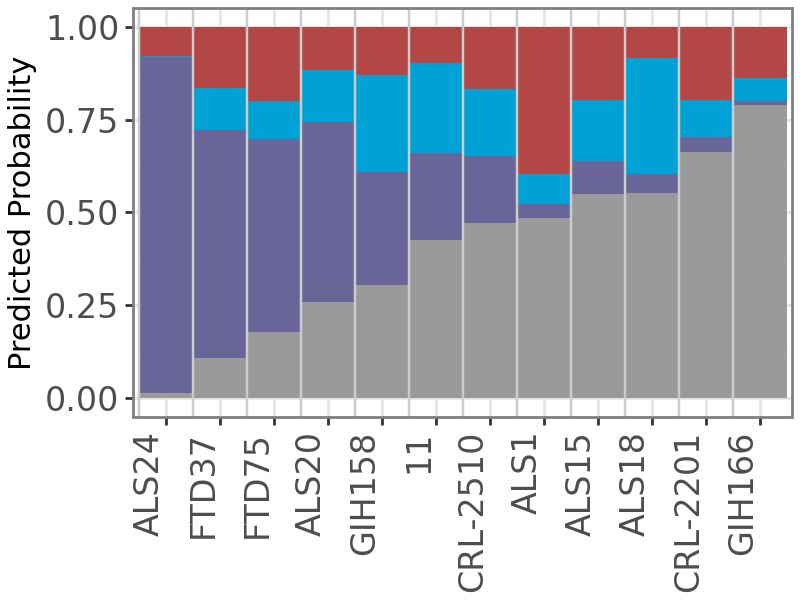

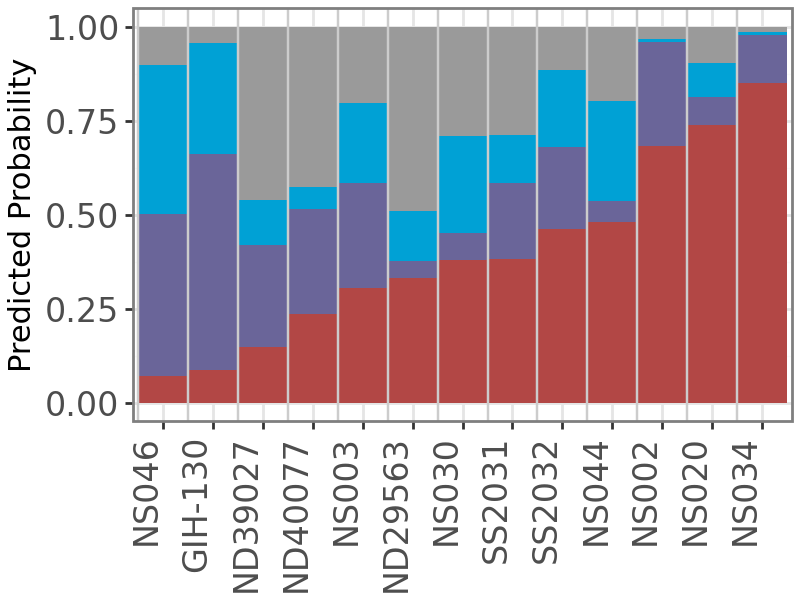

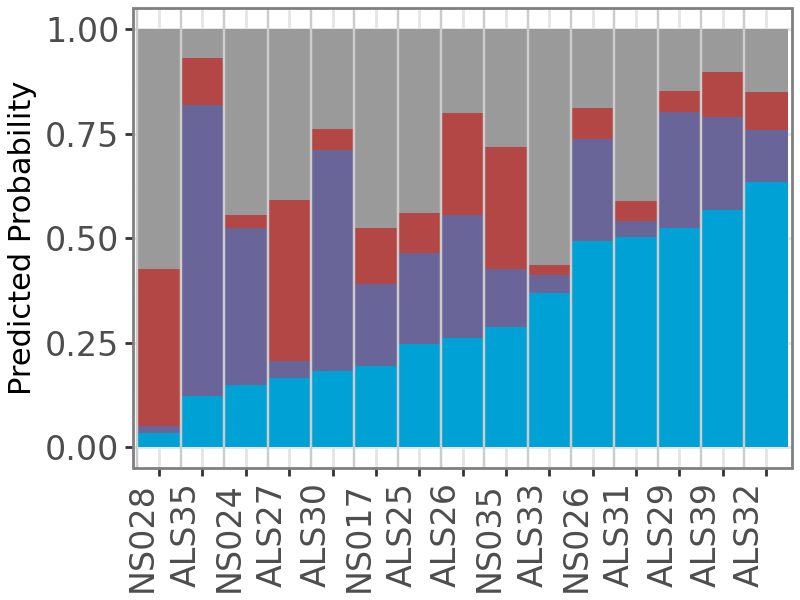

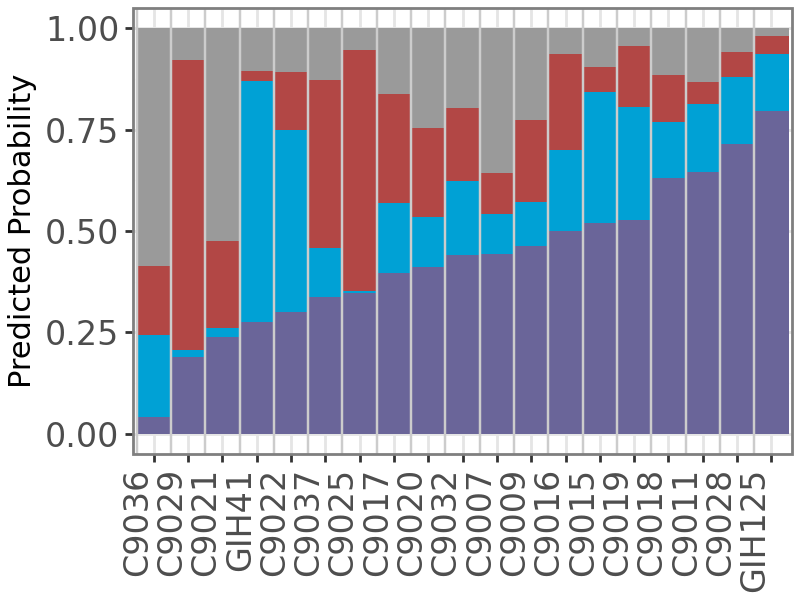

In [75]:
# Plot: Stacked bar per cell line, grouped by true mutation, ordered by predicted probability for true class
import pandas as pd
import numpy as np
from IPython.display import display
from plotnine import (
    ggplot, aes, geom_bar, theme_bw, theme, element_text, labs, ggtitle, scale_fill_manual, coord_flip
)
from maps.figures import PALETTE
from plotnine import geom_vline

# Map integer class values to mutation names
int_to_mut = {v: k for k, v in dataloader_config.response_map.items()}
df['True_mut'] = df['True'].map(int_to_mut)

# Get class probability columns
class_cols = [f'class_{i}_agg' for i in range(4)]

# For each cell line, get its true class and predicted probability for that class
df['correct_class_prob'] = df.apply(lambda row: row[f'class_{int(row["True"])}_agg'], axis=1)

# Sort by true mutation, then by correct class probability within each group
df_plot = df.sort_values(['True_mut', 'correct_class_prob']).reset_index(drop=True)

# Create a position column for ordering
df_plot['position'] = range(len(df_plot))

# For each row, reorder the class probabilities so the true class comes first
def reorder_probs(row):
    true_idx = int(row['True'])
    # Put true class first, then others in original order
    order = [true_idx] + [i for i in range(4) if i != true_idx]
    
    # Get values and cumulative positions for stacking
    vals = [row[f'class_{i}_agg'] for i in order]
    muts = [int_to_mut[i] for i in order]
    
    # Create stacked segments
    segments = []
    bottom = 0
    for i, (val, mut) in enumerate(zip(vals, muts)):
        segments.append({
            'position': row['position'],
            'CellLines': row['CellLines'],
            'True_mut': row['True_mut'],
            'mutation': mut,
            'prob': val,
            'bottom': bottom,
            'top': bottom + val,
            'order': i  # for color ordering
        })
        bottom += val
    return segments

# Create all segments
all_segments = []
for _, row in df_plot.iterrows():
    all_segments.extend(reorder_probs(row))

df_segments = pd.DataFrame(all_segments)

# Create color mapping - use PALETTE colors for mutations
color_map = PALETTE
mut_order = [int_to_mut[i] for i in range(4)]

for group_mut in mut_order:
    # Filter to only this group's cell lines
    group_data = df_segments[df_segments['True_mut'] == group_mut].copy()
    
    if group_data.empty:
        continue
    
    # Set categorical order for cell lines within this group
    group_cell_order = df_plot[df_plot['True_mut'] == group_mut]['CellLines'].tolist()
    group_data['CellLines'] = pd.Categorical(
        group_data['CellLines'], 
        categories=group_cell_order, 
        ordered=True
    )
    
    # Set categorical order for mutations with this group's true mutation first
    mut_order_for_group = [mut for mut in mut_order if mut != group_mut]
    mut_order_for_group += [group_mut]
    group_data['mutation'] = pd.Categorical(
        group_data['mutation'],
        categories=mut_order_for_group,
        ordered=True
    )
    
   # Create the plot for this group
    p = (
        ggplot(group_data, aes(x='CellLines', y='prob', fill='mutation')) +
        geom_bar(stat='identity', width=1.0) +
        #coord_flip() +
        theme_bw() +
        theme(
            axis_text_y=element_text(size=12),
            axis_text_x=element_text(size=12, angle=90, hjust=1),
            figure_size=(4, 3),
            legend_position='none'
        ) +
        labs(
            y='Predicted Probability',
            x="", 
            fill=""
        ) +
        scale_fill_manual(values=color_map)
    )
 
    # Get the number of bars (cell lines) in this group
    n_bars = len(group_cell_order) + 1
    if n_bars > 1:
        # Draw vlines between bars (at integer positions between bars)
        vlines = [i + 0.5 for i in range(n_bars - 1)]
        for v in vlines:
            p += geom_vline(xintercept=v, color="#cccccc", size=0.5)
    
    display(p)

/awlab/projects/2024_ALS/software/miniforge3/envs/maps/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


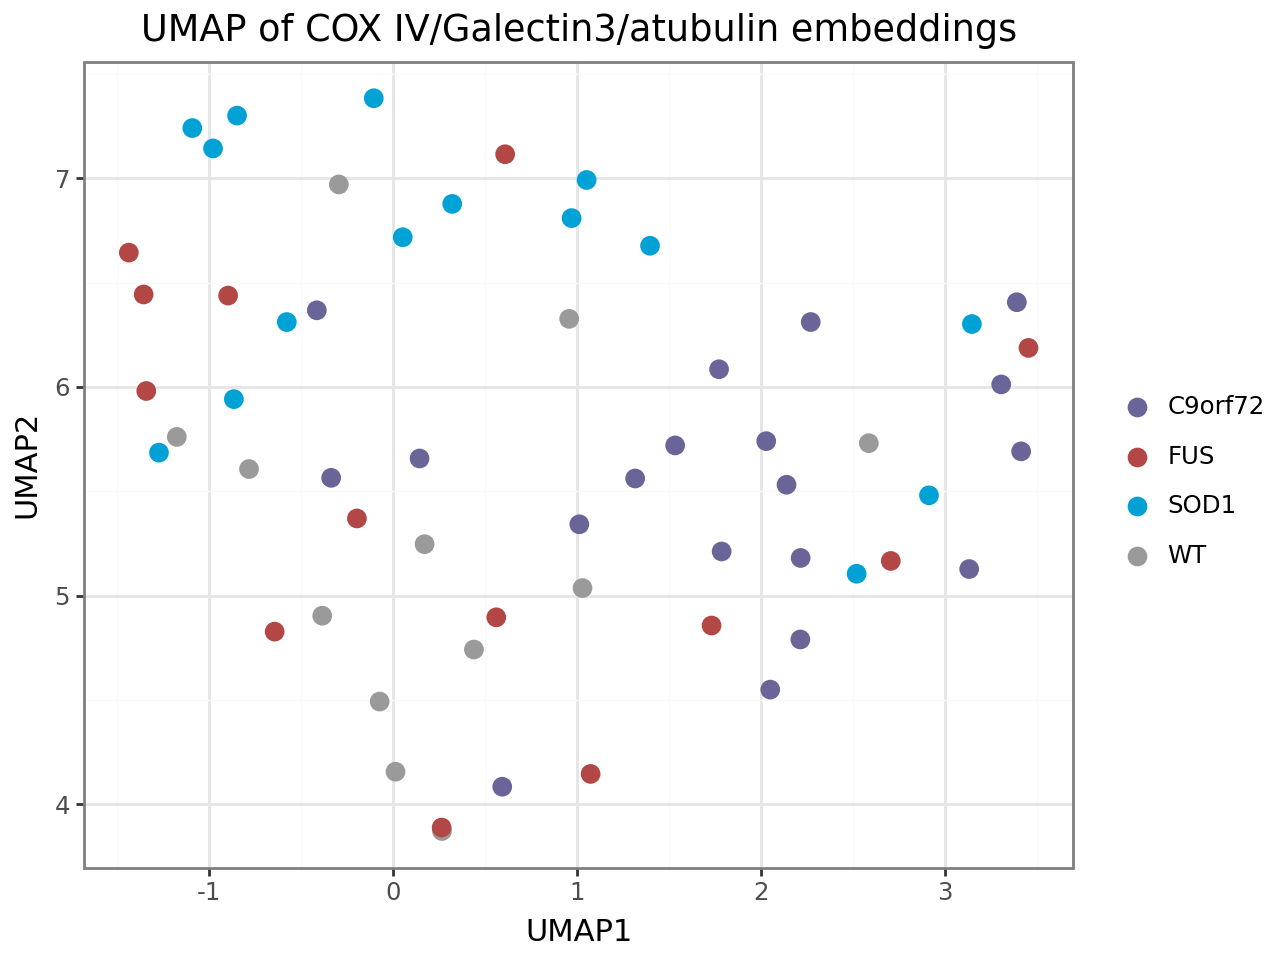

/awlab/projects/2024_ALS/software/miniforge3/envs/maps/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


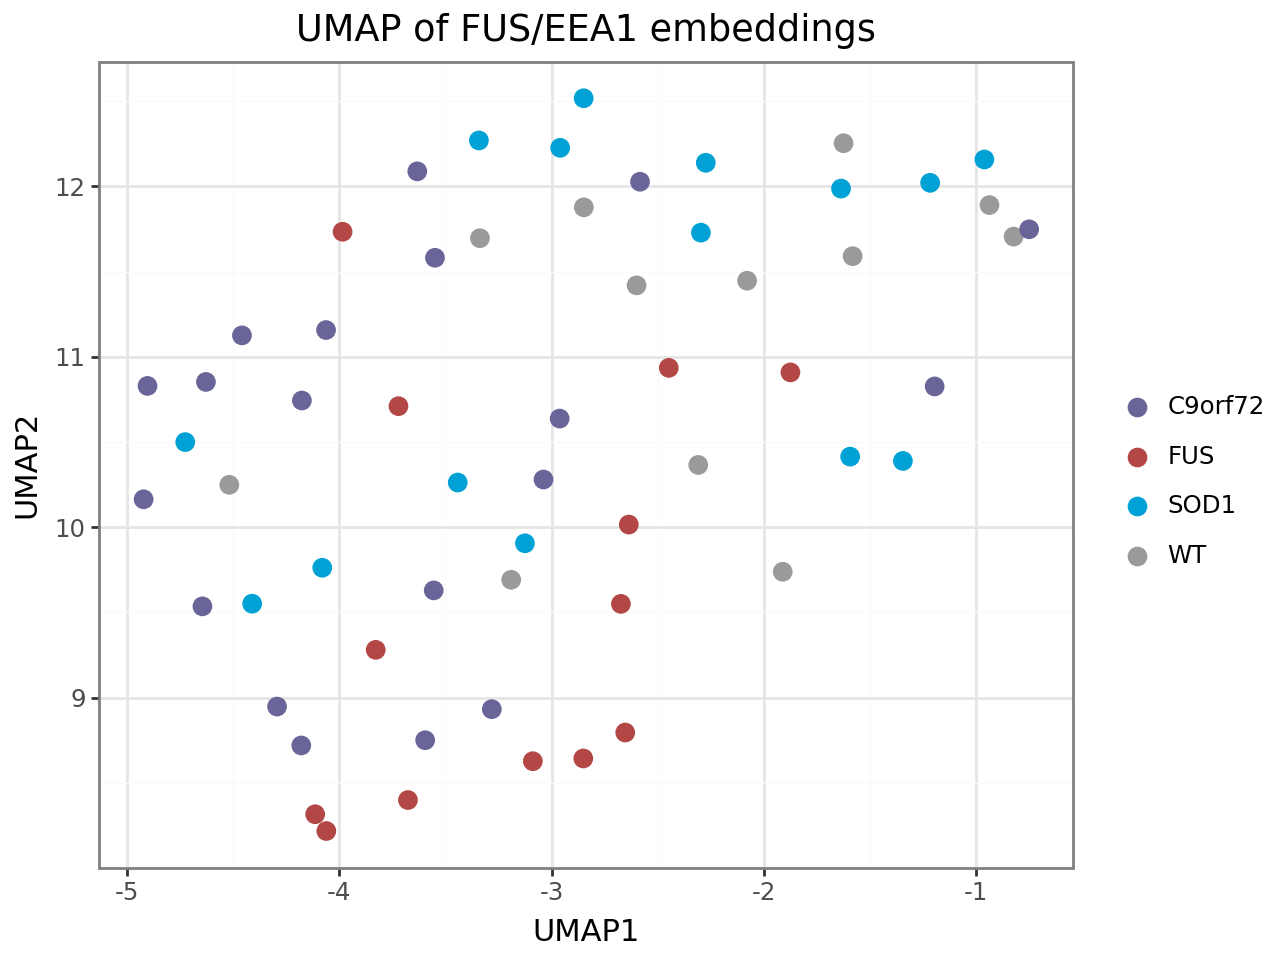

/awlab/projects/2024_ALS/software/miniforge3/envs/maps/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


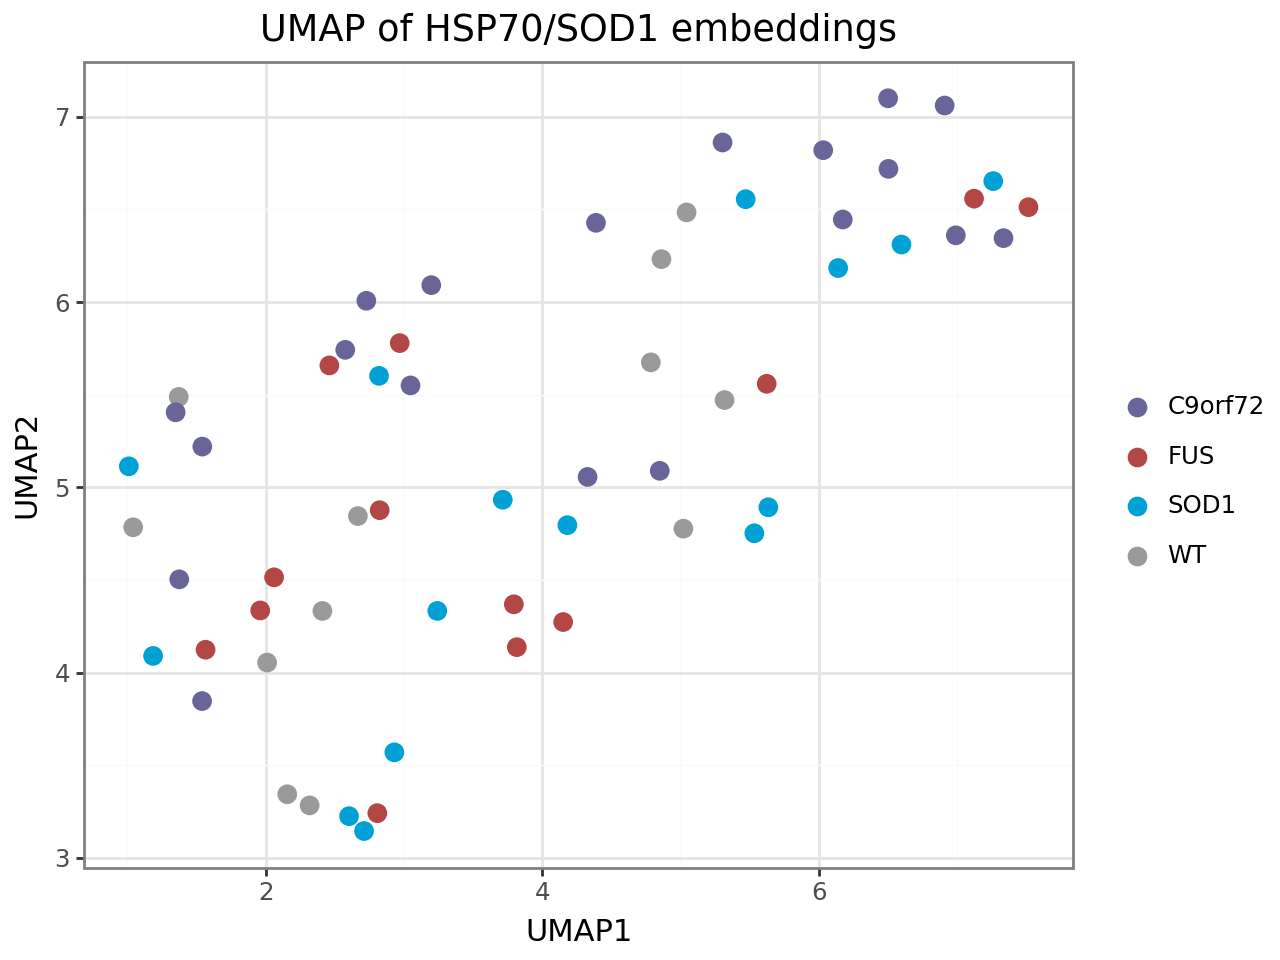

In [51]:
from plotnine import geom_point, scale_color_manual

labels = df['True'].map(int_to_mut)

# Prepare DataFrame for individual antibody UMAPs
for ab, emb in embeddings.items():
    reducer = umap.UMAP(random_state=42)
    emb_2d = reducer.fit_transform(emb.cpu().numpy())
    df_umap = pd.DataFrame({
        "UMAP1": emb_2d[:, 0],
        "UMAP2": emb_2d[:, 1],
        "Label": labels
    })
    p = (
        ggplot(df_umap, aes(x="UMAP1", y="UMAP2", color="Label")) +
        geom_point(size=3) +
        scale_color_manual(values=PALETTE) +
        labs(color="") +
        ggtitle(f"UMAP of {ab} embeddings") +
        theme_bw()
    )
    
    display(p)

In [60]:
# Compute performance metrics for each class and marker combination
from sklearn.metrics import roc_auc_score, log_loss
import numpy as np

# Create results list to store metrics
results = []

# Get true labels
true_labels = df['True'].values

# Iterate over each antibody marker
for marker in probs_cell:
    marker_probs = probs_cell[marker].numpy()
    
    # Iterate over each class
    for class_idx in range(4):
        class_name = int_to_mut[class_idx]
        
        # Binary labels for this class (1 if true class, 0 otherwise)
        binary_labels = (true_labels == class_idx).astype(int)
        
        # Predicted probabilities for this class
        class_probs = marker_probs[:, class_idx]
        
        # Compute accuracy in one-vs-all setting using argmax prediction
        predicted_class = np.argmax(marker_probs, axis=1)
        predicted_labels = (predicted_class == class_idx).astype(int)
        accuracy = (predicted_labels == binary_labels).mean()
        
        # Compute AUROC (class vs all others)
        if len(np.unique(binary_labels)) > 1:  # 
            auroc = roc_auc_score(binary_labels, class_probs)
        else:
            auroc = np.nan  # Cannot compute AUROC with only one class
        
        # Compute cross entropy in one-vs-all setting (current class as 1, all others as 0)
        eps = 1e-15
        clipped_probs = np.clip(class_probs, eps, 1-eps)
        cross_entropy = -np.mean(binary_labels * np.log(clipped_probs) + 
                               (1 - binary_labels) * np.log(1 - clipped_probs))
        
        # Store results
        results.append({
            'marker': marker,
            'class': class_name,
            'accuracy': accuracy,
            'auroc': auroc,
            'cross_entropy': cross_entropy
        })

# Create DataFrame with results
metrics_df = pd.DataFrame(results)
print("Performance metrics by marker and class:")
print(metrics_df.round(4))

Performance metrics by marker and class:
                       marker    class  accuracy   auroc  cross_entropy
0   COX IV/Galectin3/atubulin       WT    0.7288  0.7589         0.4799
1   COX IV/Galectin3/atubulin      FUS    0.6441  0.5836         0.5226
2   COX IV/Galectin3/atubulin     SOD1    0.7797  0.7818         0.4980
3   COX IV/Galectin3/atubulin  C9orf72    0.7966  0.8237         0.5530
4                    FUS/EEA1       WT    0.7288  0.7571         0.4810
5                    FUS/EEA1      FUS    0.8475  0.8645         0.4309
6                    FUS/EEA1     SOD1    0.5932  0.6864         0.5376
7                    FUS/EEA1  C9orf72    0.7119  0.7092         0.5982
8                  HSP70/SOD1       WT    0.6780  0.5869         0.5063
9                  HSP70/SOD1      FUS    0.7288  0.5987         0.5490
10                 HSP70/SOD1     SOD1    0.7119  0.6561         0.5676
11                 HSP70/SOD1  C9orf72    0.7288  0.7461         0.5679


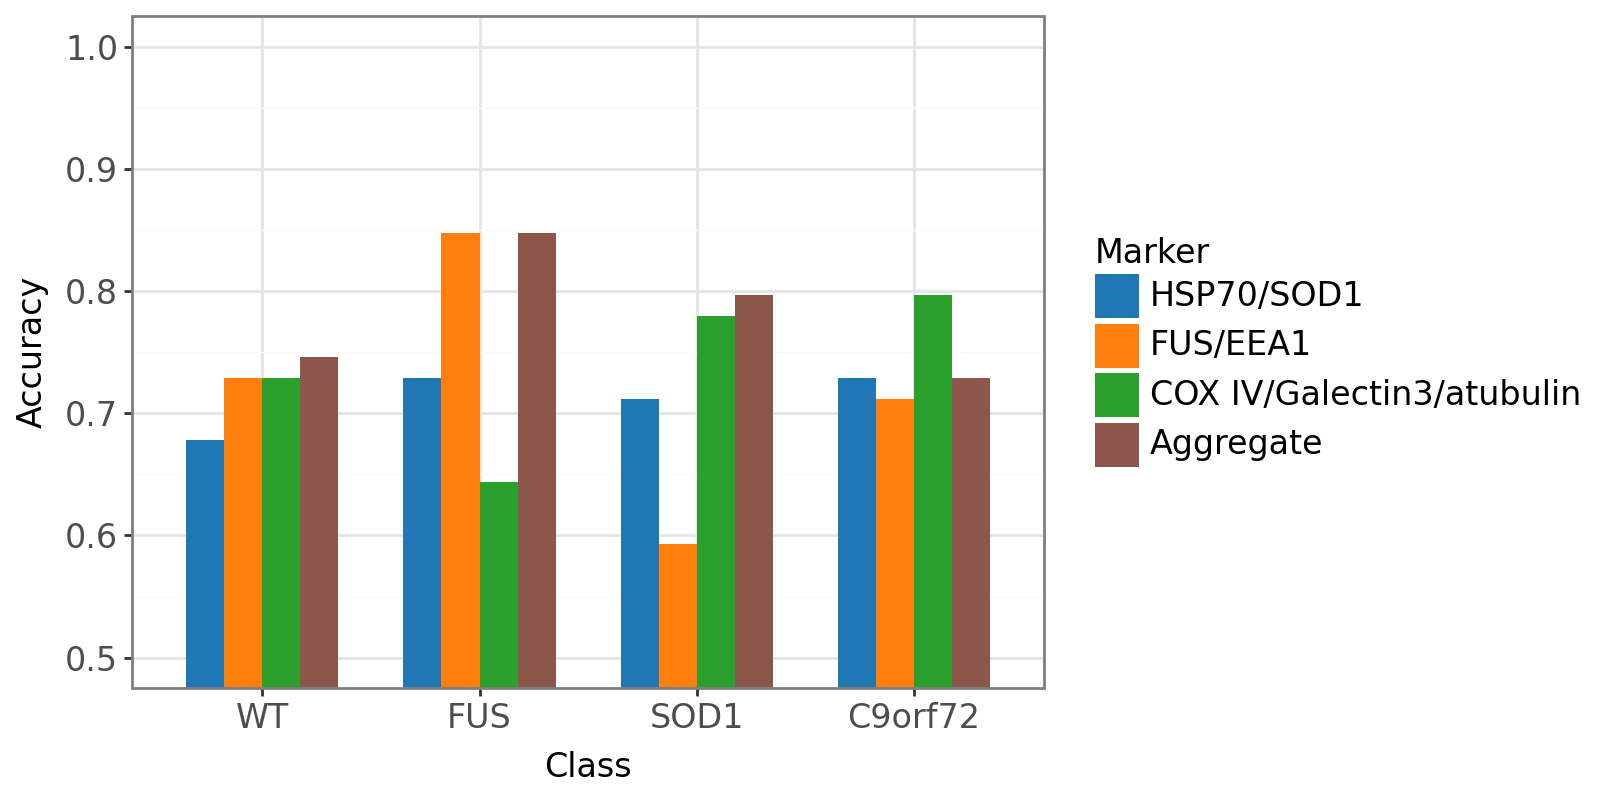

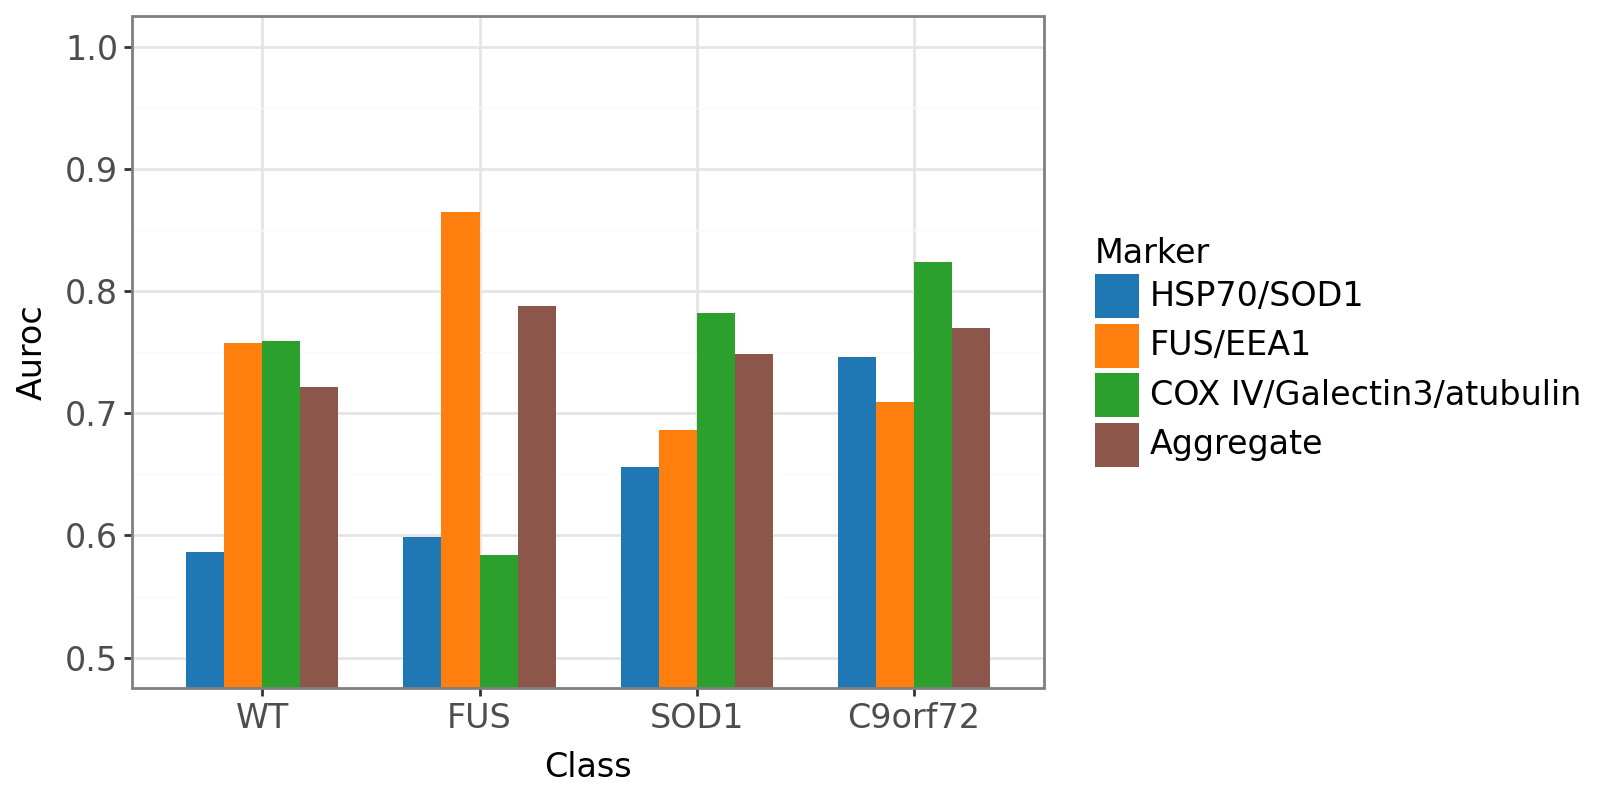

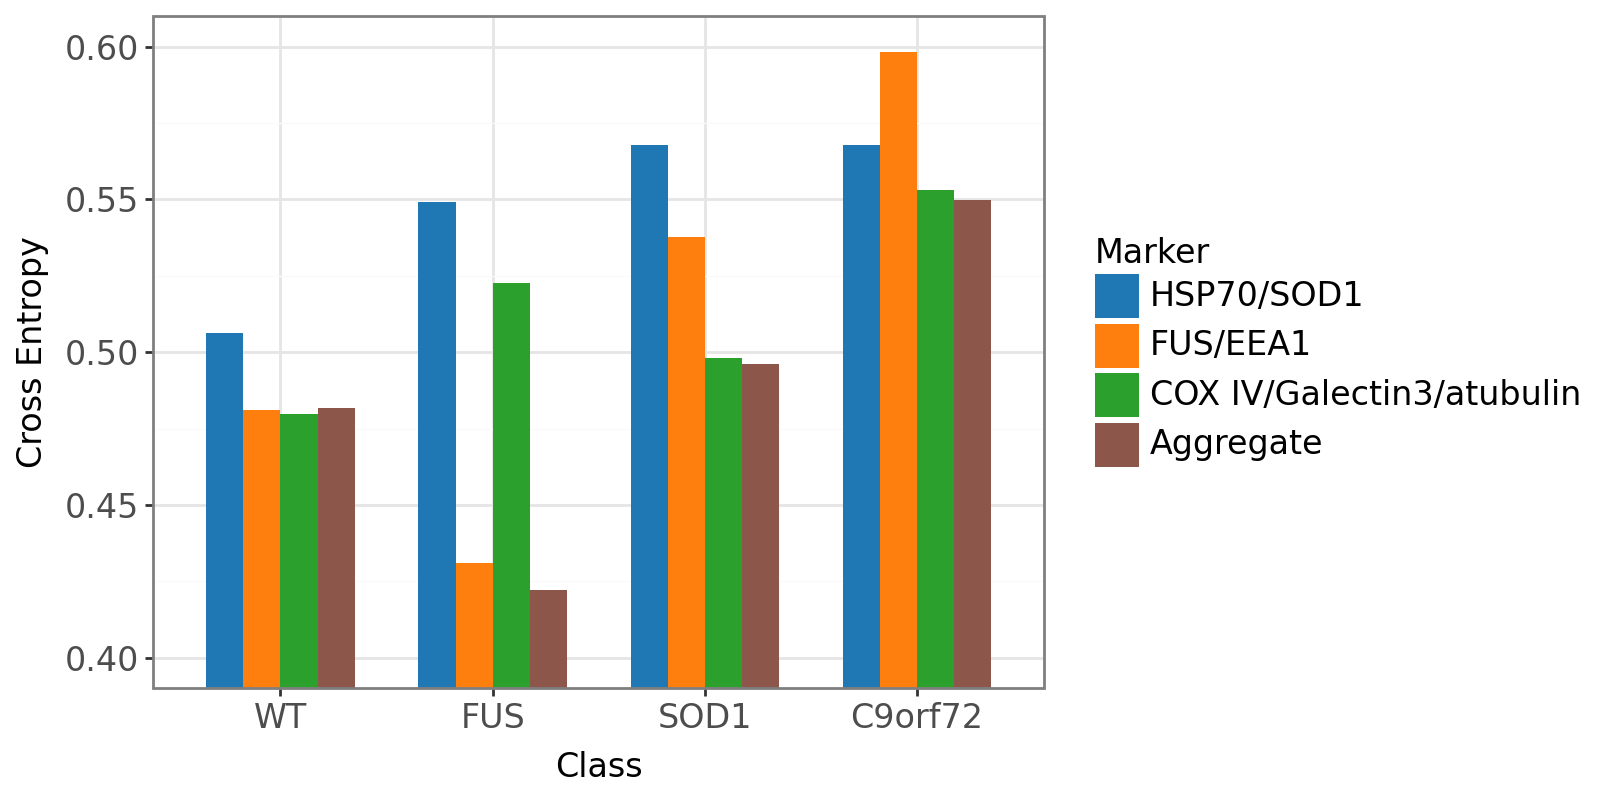

In [94]:
# Create barplots showing accuracy, AUROC, and cross entropy by marker for each class (merged over classes, including aggregate predictions)
from plotnine import ggplot, aes, geom_bar, theme_bw, theme, element_text, labs, ggtitle, scale_fill_manual, coord_cartesian, geom_text, position_dodge

# --- Compute aggregate metrics using probs_line ---
from sklearn.metrics import roc_auc_score, log_loss
import numpy as np

agg_results = []
true_labels = df['True'].values
agg_probs = probs_line.numpy()

for class_idx in range(4):
    class_name = int_to_mut[class_idx]
    binary_labels = (true_labels == class_idx).astype(int)
    class_probs = agg_probs[:, class_idx]
    predicted_class = np.argmax(agg_probs, axis=1)
    predicted_labels = (predicted_class == class_idx).astype(int)
    accuracy = (predicted_labels == binary_labels).mean()
    if len(np.unique(binary_labels)) > 1:
        auroc = roc_auc_score(binary_labels, class_probs)
    else:
        auroc = np.nan
    eps = 1e-15
    clipped_probs = np.clip(class_probs, eps, 1-eps)
    cross_entropy = -np.mean(binary_labels * np.log(clipped_probs) + (1 - binary_labels) * np.log(1 - clipped_probs))
    agg_results.append({
        'marker': 'Aggregate',
        'class': class_name,
        'accuracy': accuracy,
        'auroc': auroc,
        'cross_entropy': cross_entropy
    })

agg_metrics_df = pd.DataFrame(agg_results)

# --- Merge with per-marker metrics ---
metrics_merged = pd.concat([metrics_df, agg_metrics_df], ignore_index=True)

# Reshape data for faceting (melt to long format)
plot_data = metrics_merged.melt(
    id_vars=['marker', 'class'], 
    value_vars=['accuracy', 'auroc', 'cross_entropy'],
    var_name='metric', 
    value_name='value'
 )

# Create categorical ordering for markers and classes
plot_data['marker'] = pd.Categorical(
    plot_data['marker'], 
    categories=antibodies + ['Aggregate'], 
    ordered=True
)
plot_data['class'] = pd.Categorical(
    plot_data['class'], 
    categories=['WT', 'FUS', 'SOD1', 'C9orf72'], 
    ordered=True
)

# Plot for each metric, with class as x-axis and marker as fill/color
for metric in ['accuracy', 'auroc', 'cross_entropy']:
    metric_data = plot_data[plot_data['metric'] == metric].copy()
    
    # Set appropriate y-limits and label offset
    if metric in ['accuracy', 'auroc']:
        y_limits = (0.5, 1.0)
        y_offset = 0.02
    else:  # cross_entropy
        y_limits = (0.4, 0.6)
        y_offset = 0.07
    
    # Add a column for value labels as float (not string)
    metric_data['label'] = metric_data['value'].round(2)
    metric_data['y_label'] = metric_data['value'] + y_offset
    
    dodge = position_dodge(width=0.7)
    
    p = (
        ggplot(metric_data, aes(x='class', y='value', fill='marker')) +
        geom_bar(stat='identity', position=dodge, width=0.7) +
        #geom_text(aes(label='label', y='y_label', group='marker'), format_string='{:.2f}', size=10, position=dodge, angle=90) +
        coord_cartesian(ylim=y_limits) +
        theme_bw() +
        theme(
            text=element_text(size=12),
            figure_size=(8, 4),
            legend_position='right'
        ) +
        labs(
            x='Class',
            y=metric.replace('_', ' ').title(),
            fill='Marker'
        ) +
        scale_fill_manual(values=['#1f77b4', '#ff7f0e', '#2ca02c', '#8c564b'])
    )
    
    display(p)

/awlab/projects/2024_ALS/software/miniforge3/envs/maps/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


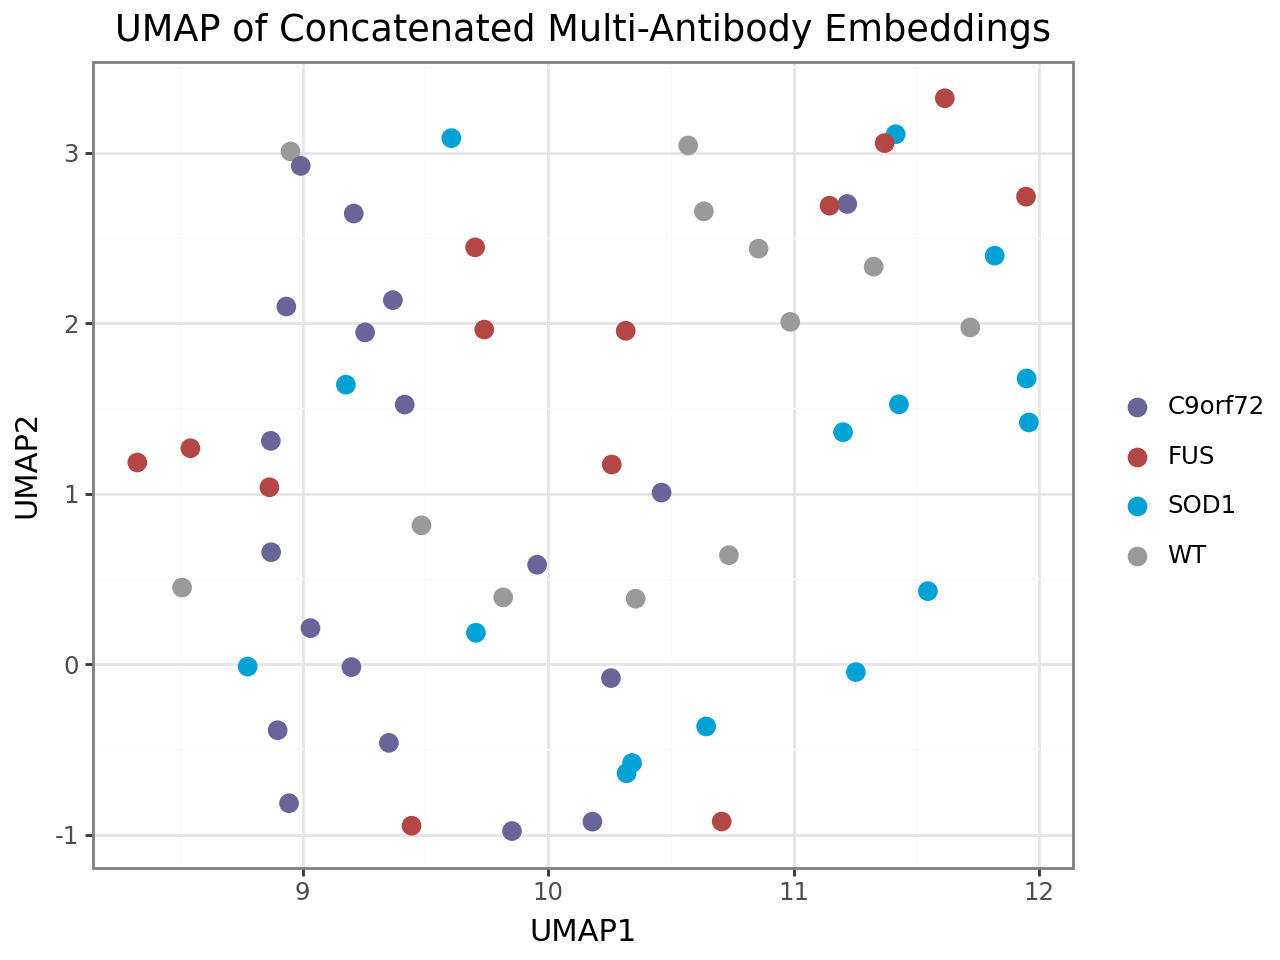

In [52]:
# Create UMAP from concatenated embeddings across all antibody markers
from plotnine import geom_point, scale_color_manual

# Concatenate embeddings from all antibodies
all_embeddings = []
for ab in antibodies:
    if ab in embeddings:
        all_embeddings.append(embeddings[ab])

# Concatenate along feature dimension (axis=1)
if all_embeddings:
    concat_embeddings = torch.cat(all_embeddings, dim=1)
    
    # Create UMAP from concatenated embeddings
    reducer = umap.UMAP(random_state=42)
    emb_2d = reducer.fit_transform(concat_embeddings.cpu().numpy())
    
    labels = df['True'].map(int_to_mut)
    
    df_umap_concat = pd.DataFrame({
        "UMAP1": emb_2d[:, 0],
        "UMAP2": emb_2d[:, 1],
        "Label": labels
    })
    
    p = (
        ggplot(df_umap_concat, aes(x="UMAP1", y="UMAP2", color="Label")) +
        geom_point(size=3) +
        scale_color_manual(values=PALETTE) +
        labs(color="") +
        ggtitle("UMAP of Concatenated Multi-Antibody Embeddings") +
        theme_bw()
    )
    
    display(p)
else:
    print("No embeddings found to concatenate")